In [1]:
import os
import sys
import json
import time

import cv2
import dlib
import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt

In [38]:
import os.path as path

In [2]:
%load_ext autoreload
%autoreload 10

In [3]:
%reload_ext autoreload

In [7]:
sys.path.append("../")

# our own module for face recognition
import facelib
from facelib.transforms import FaceHaarDetectCrop, FaceAlign
from facelib.utils import load_face_dataset

In [42]:
dir_cropped = "../data/processed/cropped/"

# load dataset to CPU RAM
images, file_paths = load_face_dataset(dir_cropped)

def get_dirname(file_path):
    return path.basename(os.path.dirname(file_path))

# create labels for person recognition by looking at dirname
dirnames = [get_dirname(file_path) for file_path in file_paths]
names_to_labels = {dirname: idx for idx, dirname in enumerate(np.unique(dirnames))}  # label is encoded as int

labels_recog = [names_to_labels[dirname] for dirname in dirnames]

In [43]:
# create labels for emotion recognition by looking at filename suffix
# e.g. ..../daniel_smile.jpg
def get_filename_suffix(file_path):
    return path.splitext(path.basename(file_path))[0].split('_')[-1]

emotions = [get_filename_suffix(file_path) for file_path in file_paths]
emo_to_labels = {emo: idx for idx, emo in enumerate(np.unique(emotions))}

labels_emo = [emo_to_labels[emo] for emo in emotions]

#### Sanity Check: Labels?

In [44]:
emo_to_labels

{'neutral': 0, 'sad': 1, 'sleep': 2, 'smile': 3, 'surprised': 4}

In [45]:
names_to_labels

{'adeline': 0,
 'asur': 1,
 'billy': 2,
 'christopher': 3,
 'daniel': 4,
 'hans': 5,
 'hyung': 6,
 'kevin': 7,
 'krismanto': 8,
 'lavando': 9,
 'leonardo': 10,
 'marco': 11,
 'melina': 12,
 'michael': 13,
 'norman': 14,
 'richardson': 15,
 'ryan': 16,
 'sergi': 17,
 'zaky': 18}

In [46]:
len(labels_recog)

94

In [47]:
len(labels_emo)

94

#### Convert Image to Gray

In [65]:
gray_images = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images])

In [66]:
type(gray_images)

numpy.ndarray

In [68]:
gray_images.shape

(94, 300, 300)

## PCA

In [69]:
# ravel images into flat vector
n_data, h, w = gray_images.shape
X_train = gray_images.reshape(n_data, -1)  # flatten by reshaping

In [74]:
n_components = 50
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)

# get eigenfaces from the projected component
eigenfaces = pca.components_.reshape((n_components, h, w))

In [75]:
X_train_pca = pca.transform(X_train)

In [76]:
X_train_pca.shape

(94, 50)

### Classification Model: Recognition

In [80]:
param_grid = {'alpha': [1e-1, 5e-3], 
              'loss': ['log', 'hinge'],
              'learning_rate':['adaptive', 'optimal'],
              'n_jobs': [-1], 
              'class_weight': ['balanced'],
              'eta0': [3e-3, 3e-2]}

clf = GridSearchCV(SGDClassifier(), param_grid)
clf = clf.fit(X_train_pca, labels_recog)

print("Best estimator found by grid search:")
print(clf.best_estimator_)

/home/students/student3_17/.pyvirtualenvs/pytorch-1.4.1+cv2/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Best estimator found by grid search:
SGDClassifier(alpha=0.005, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.003, fit_intercept=True,
              l1_ratio=0.15, learning_rate='adaptive', loss='log',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [90]:
import seaborn as sns

              precision    recall  f1-score   support

     adeline       1.00      1.00      1.00         5
        asur       1.00      1.00      1.00         5
       billy       1.00      1.00      1.00         4
 christopher       1.00      1.00      1.00         5
      daniel       1.00      1.00      1.00         5
        hans       1.00      1.00      1.00         5
       hyung       1.00      1.00      1.00         5
       kevin       1.00      1.00      1.00         5
   krismanto       1.00      1.00      1.00         5
     lavando       1.00      1.00      1.00         5
    leonardo       1.00      1.00      1.00         4
       marco       1.00      1.00      1.00         5
      melina       1.00      1.00      1.00         5
     michael       1.00      1.00      1.00         5
      norman       1.00      1.00      1.00         5
  richardson       1.00      1.00      1.00         6
        ryan       1.00      1.00      1.00         5
       sergi       1.00    

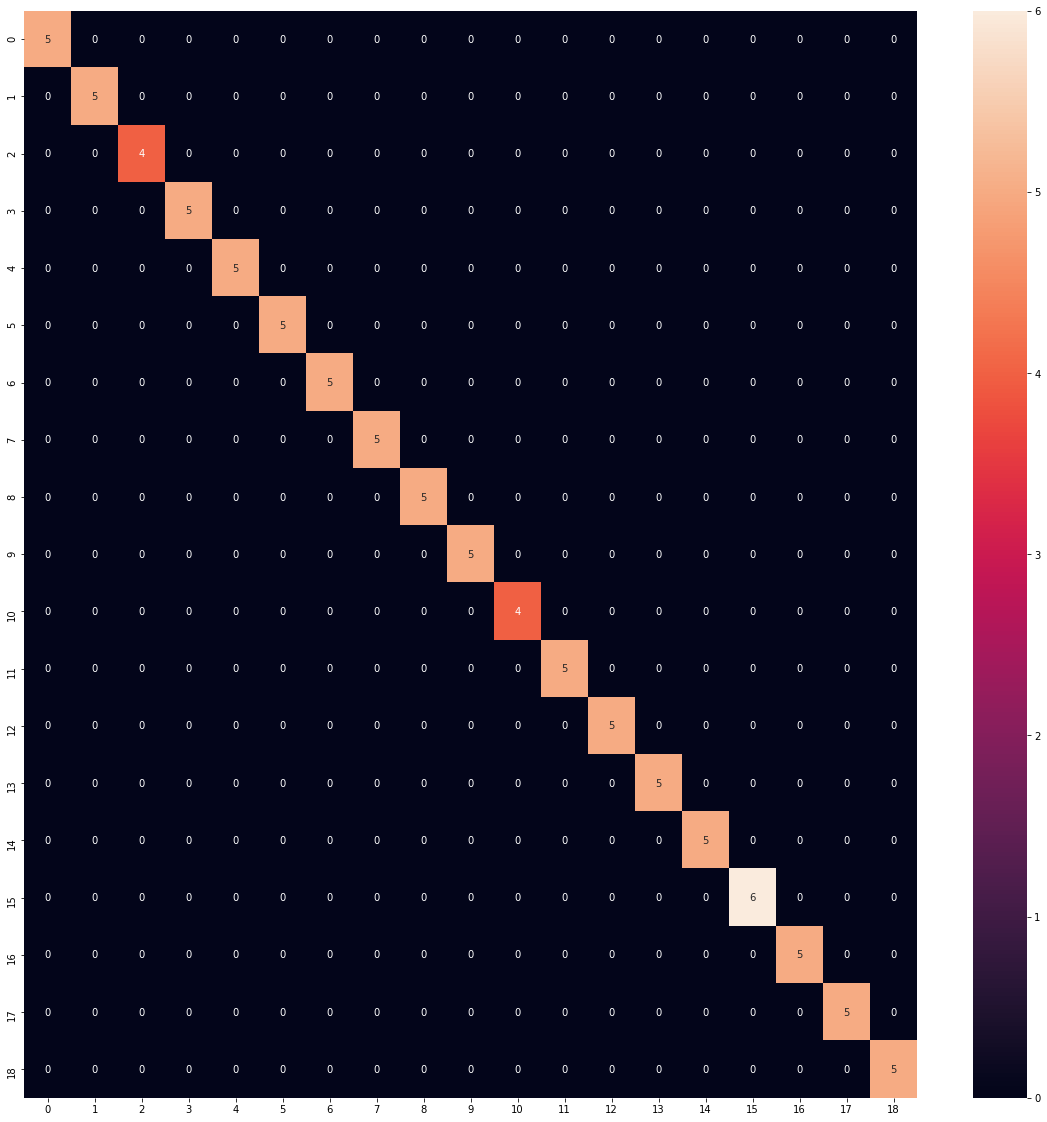

In [93]:
y_pred = clf.predict(X_train_pca)

print(classification_report(labels_recog, y_pred, target_names=np.unique(dirnames)))

plt.figure(figsize=(20,20))
confusion_mat = confusion_matrix(labels_recog, y_pred, labels=np.unique(labels_recog))
sns.heatmap(confusion_mat, annot=True)

In [145]:
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.axis('off')
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)

In [110]:
eigenfaces.shape

(50, 300, 300)

In [114]:
sample_indices = np.random.choice(len(prediction_titles), size=25, replace=False)

In [139]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name[:6], true_name[:6])

<Figure size 1440x1440 with 0 Axes>

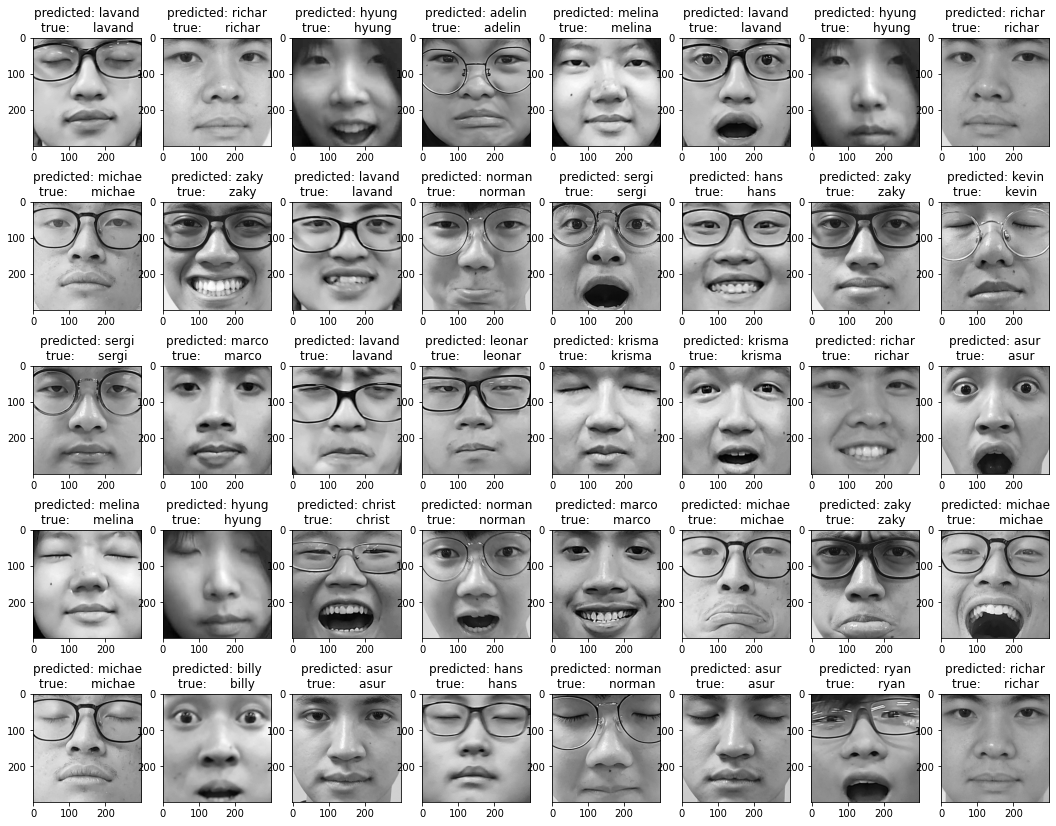

In [146]:
prediction_titles = [title(y_pred, labels_recog, np.unique(dirnames), i)
                     for i in range(y_pred.shape[0])]
sample_indices = np.random.choice(len(prediction_titles), size=50, replace=False)

plt.figure(figsize=(20,20))
train_faces = X_train[sample_indices]
sample_names = np.array(prediction_titles)[sample_indices]
plot_gallery(train_faces, sample_names, h, w, n_row=5, n_col=8)

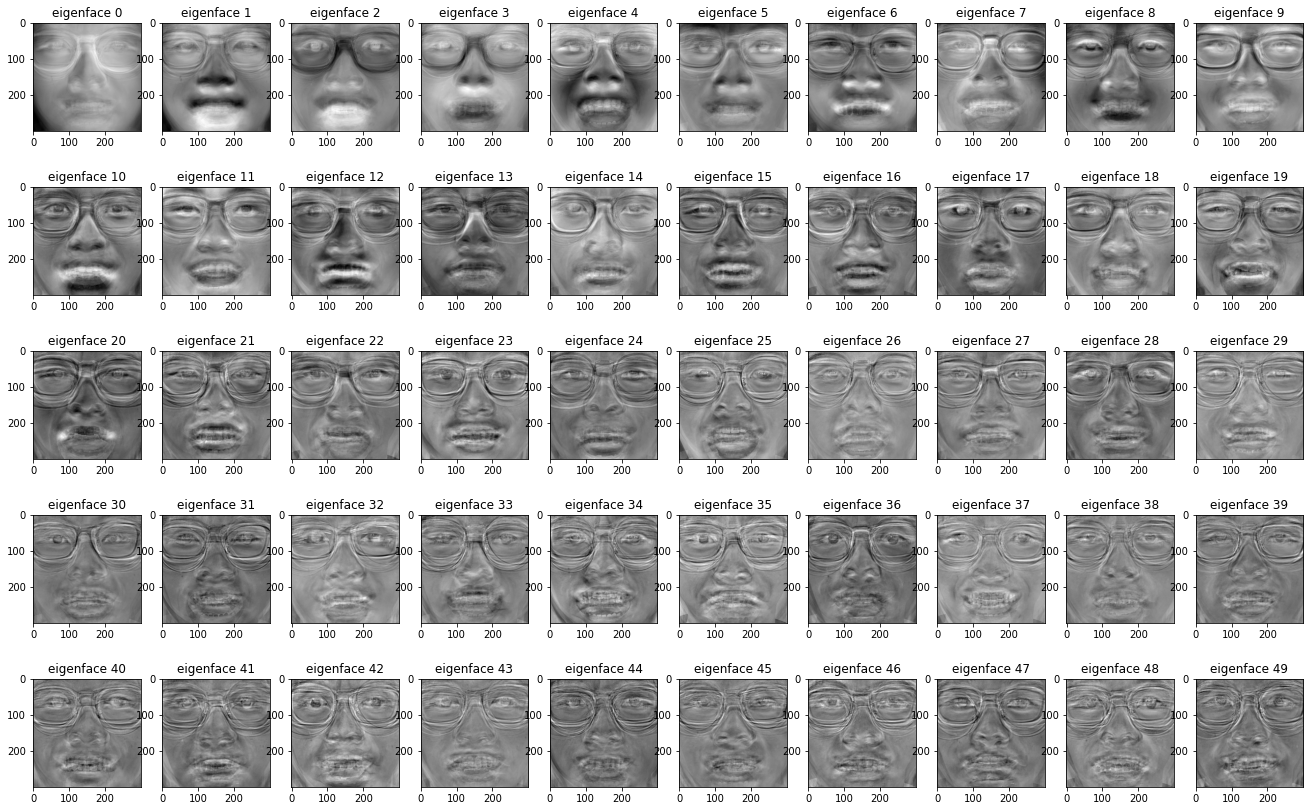

In [125]:
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w, n_row=5, n_col=10)

plt.show()

In [89]:
eigenfaces.shape

(50, 300, 300)

### Classification: Emotion

In [94]:
param_grid = {'alpha': [1e-1, 5e-3], 
              'loss': ['log', 'hinge'],
              'learning_rate':['adaptive', 'optimal'],
              'n_jobs': [-1], 
              'class_weight': ['balanced'],
              'eta0': [3e-3, 3e-2]}

clf_emo = GridSearchCV(SGDClassifier(), param_grid)
clf_emo = clf.fit(X_train_pca, labels_emo)

print("Best estimator found by grid search:")
print(clf_emo.best_estimator_)

Best estimator found by grid search:
SGDClassifier(alpha=0.1, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.003, fit_intercept=True,
              l1_ratio=0.15, learning_rate='adaptive', loss='log',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


              precision    recall  f1-score   support

     neutral       0.90      0.86      0.88        21
         sad       0.94      0.94      0.94        17
       sleep       0.89      1.00      0.94        17
       smile       1.00      0.95      0.98        21
   surprised       1.00      1.00      1.00        18

    accuracy                           0.95        94
   macro avg       0.95      0.95      0.95        94
weighted avg       0.95      0.95      0.95        94



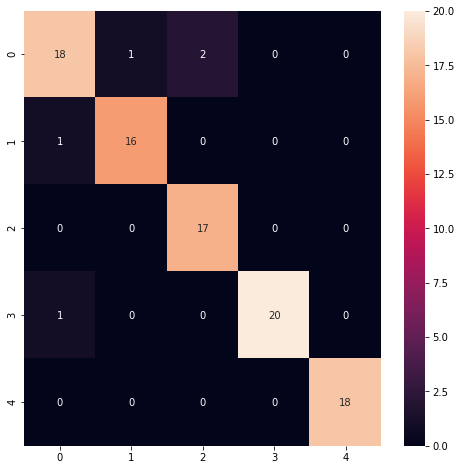

In [109]:
y_pred_emo = clf_emo.predict(X_train_pca)

print(classification_report(labels_emo, y_pred_emo, target_names=np.unique(emotions)))

plt.figure(figsize=(8,8))
confusion_mat = confusion_matrix(labels_emo, y_pred_emo, labels=np.unique(labels_emo))
sns.heatmap(confusion_mat, annot=True)

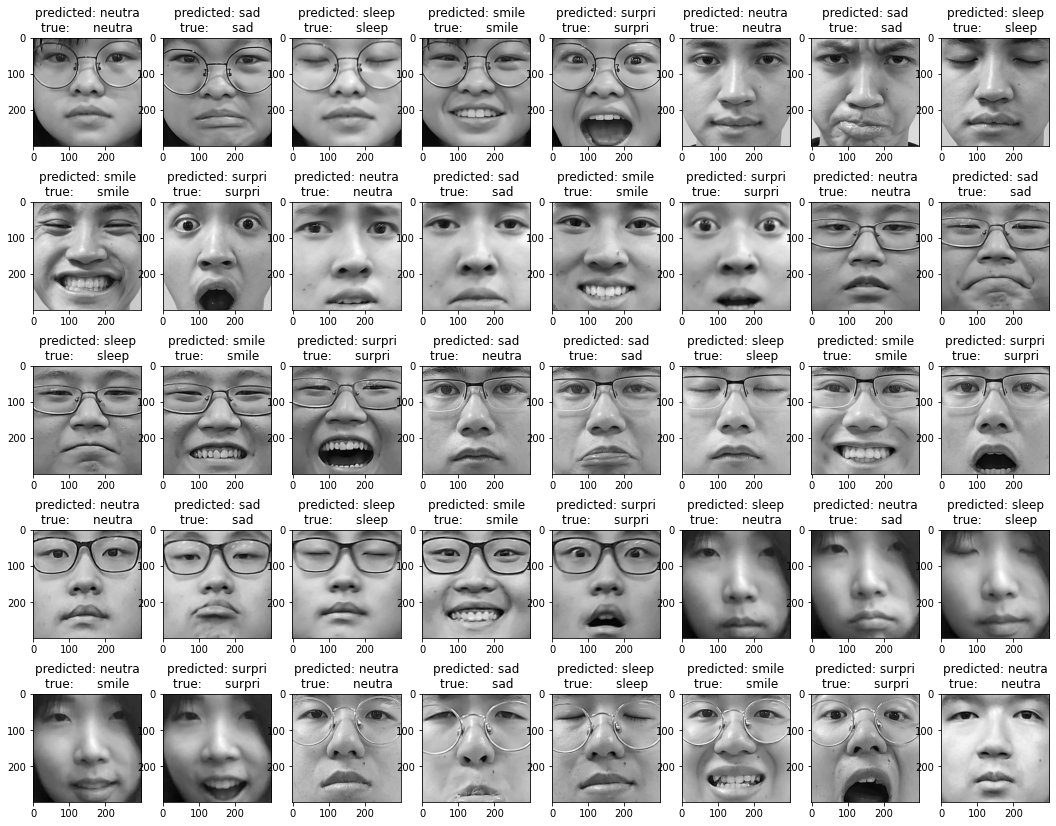

In [147]:
sample_indices = np.random.choice(len(prediction_titles), size=50, replace=False)

prediction_titles = [title(y_pred_emo, labels_emo, np.unique(emotions), i)
                     for i in range(y_pred_emo.shape[0])]

train_faces = X_train[sample_indices]
sample_names = np.array(prediction_titles)[sample_indices]

plot_gallery(X_train, prediction_titles, h, w, n_row=5, n_col=8)

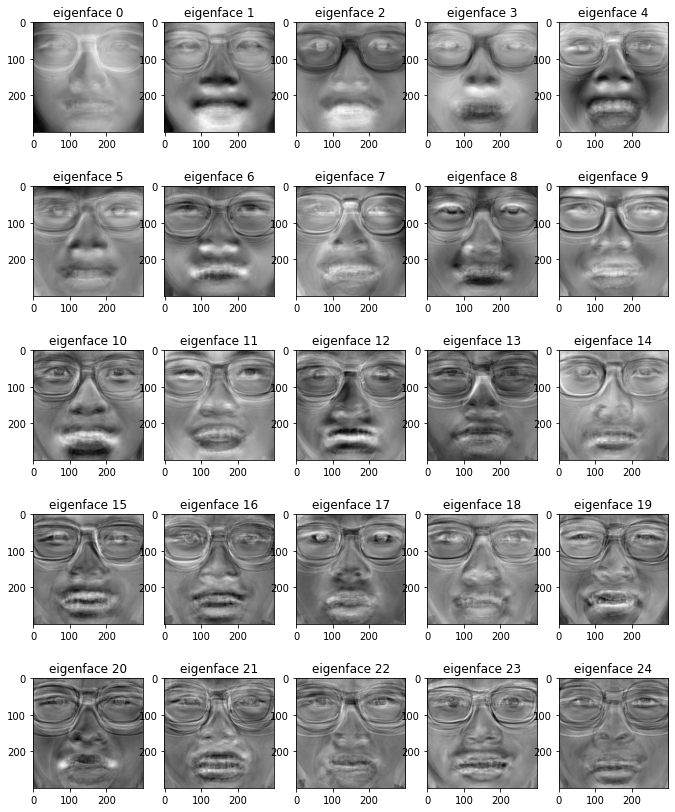

In [124]:
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w, n_row=5, n_col=5)

plt.show()

In [98]:
len(y_pred_emo)

94

In [99]:
np.unique(y_pred_emo)

array([0, 1, 2, 3, 4])

In [100]:
np.unique(labels_emo)

array([0, 1, 2, 3, 4])

## Testing split 

In [105]:
def _crop_from_rect(image, rect):
    # single face mode where only one rectangle per image
    # rectangle here denote bounding box of a face in an image
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    face = image[y:y+h, x:x+w, :]
    return face

def _crop_from_rects(image, rects):
    # multi face mode where one image map to many rectangles
    # rectangle here denote bounding box of a face in an image
    faces = []
    for rect in rects:
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        face = image[y:y+h, x:x+w, :]
        faces.append(face)
    return faces

In [102]:
# test sample data
together_path = "together.jpg"

In [103]:
together = cv2.imread(together_path)

In [ ]:
face_detection